In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Description:
In this notebook, we will explore LSTM models' accuracy in one-step-ahead (daily) weather forecast

#Part 1: Data Preparation

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#Reading data from Google Drive
#This dataset is private, so I cannot share
weather = pd.read_csv("https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawa_daily.csv", on_bad_lines='skip')
weather = weather[['date', 'avg_hourly_temperature', 'precipitation', 'avg_hourly_pressure_station', 'solar_radiation']]
# weather = weather[['date', 'avg_hourly_temperature', 'precipitation', 'avg_hourly_pressure_station']]

In [5]:
weather = weather.rename(columns={'avg_hourly_temperature': 'temperature', 'datetime': 'date'})
weather['date'] = pd.to_datetime(weather['date'])
weather['solar_radiation'].interpolate(method='linear', inplace=True)
weather.set_index('date')
weather.head(5)

,date,temperature,precipitation,avg_hourly_pressure_station,solar_radiation
0,2024-01-31,-3.24,0.0,100.23,3637.0
1,2024-01-30,-6.08,0.0,100.78,5897.0
2,2024-01-29,-2.75,0.0,100.27,5938.0
3,2024-01-28,0.35,0.0,100.16,3660.0
4,2024-01-27,0.28,0.2,100.92,3350.0


Data description:

* date: YYYY-MM-DD

* temperature: average temperature at the given date, in degrees Celcius

* precip: precipitation, in mm

* avg pressure: average pressure hourly in bar

* solar radiation: power of the sun

Will be filling NA values of solar radiation with interpolation


In [6]:
weather.isna().sum()

date                           0
temperature                    0
precipitation                  0
avg_hourly_pressure_station    0
solar_radiation                0
dtype: int64

There are only a few other NA values, deleting these rows will result negligible data loss.

In [7]:
weather.dropna(inplace=True)
weather.info

<bound method DataFrame.info of            date  temperature  precipitation  avg_hourly_pressure_station  \
0    2024-01-31        -3.24            0.0                       100.23   
1    2024-01-30        -6.08            0.0                       100.78   
2    2024-01-29        -2.75            0.0                       100.27   
3    2024-01-28         0.35            0.0                       100.16   
4    2024-01-27         0.28            0.2                       100.92   
...         ...          ...            ...                          ...   
9995 1996-09-19        16.02            0.0                        99.99   
9996 1996-09-18        16.47            0.0                        99.92   
9997 1996-09-17        15.36            0.0                       100.19   
9998 1996-09-16        12.77            0.4                       100.08   
9999 1996-09-15        12.75            3.0                        99.67   

      solar_radiation  
0              3637.0  
1              5897.0  
2              5938.0  
3              3660.0  
4              3350.0  
...               ...  
9995           7286.0  
9996           7286.0  
9997           7286.0  
9998           7286.0  
9999           7286.0  

[10000 rows x 5 columns]>

In [8]:
weather['month'] = weather['date'].dt.month

In [9]:
weather.head(2)

,date,temperature,precipitation,avg_hourly_pressure_station,solar_radiation,month
0,2024-01-31,-3.24,0.0,100.23,3637.0,1
1,2024-01-30,-6.08,0.0,100.78,5897.0,1


Our main dataframe will be "weather". Let's examine the data even more:

In [10]:
weather_seperated = weather[['date', 'month', 'temperature']].copy(deep=True)
weather_seperated['year'] = weather['date'].dt.year
weather_seperated.drop(['date'], axis=1, inplace=True)
weather_seperated = weather_seperated.pivot_table(index='month',  columns='year', values='temperature')
weather_seperated.head(2)

year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
month,,,,,,,,,,,,,,,,,,,,,
1,NaN,-11.298710,-7.659677,-10.105161,-10.137419,-8.94129,-4.368710,-12.931613,-15.338065,-11.649032,...,-12.693226,-7.368065,-5.273871,-9.705484,-11.625484,-5.859355,-7.113226,-14.294516,-5.212903,-5.981935
2,NaN,-7.494643,-3.671071,-5.802500,-6.652759,-8.39000,-5.790357,-11.391429,-7.413793,-6.818929,...,-15.747500,-7.684828,-4.987857,-4.551071,-8.887500,-6.590345,-8.090714,-8.540714,-6.970357,NaN


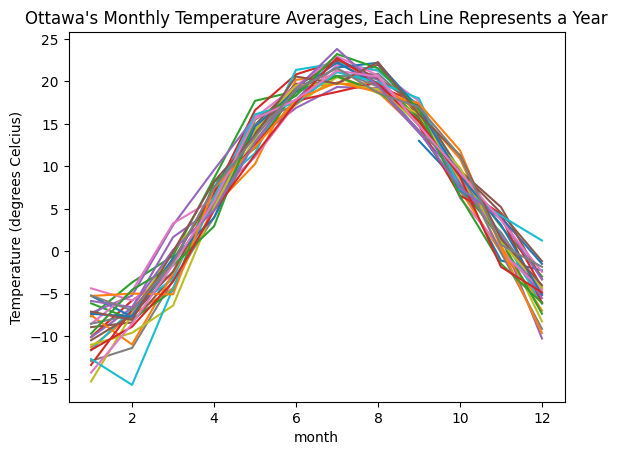

In [11]:
weather_seperated.plot()
plt.ylabel('Temperature (degrees Celcius)')
plt.title("Ottawa's Monthly Temperature Averages, Each Line Represents a Year")
plt.legend().remove()
plt.show()

From the chart, we can see monthly temperature averages follow a meaningful seasonal trend.

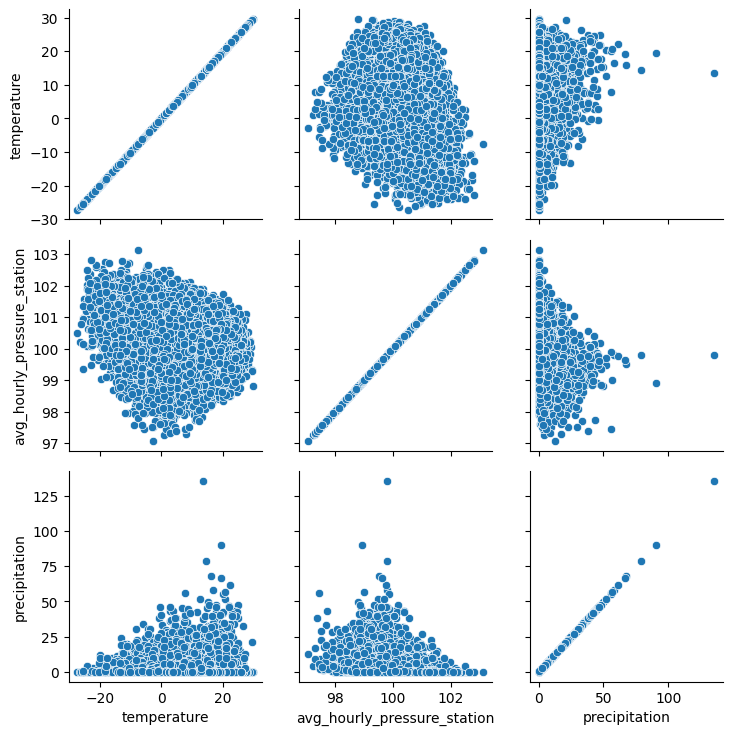

In [12]:
g = sns.PairGrid(weather[['temperature', 'avg_hourly_pressure_station', 'precipitation', 'solar_radiation']])
g.map(sns.scatterplot)

#Part 2: Checking the Naive prediction's error

A naive temperature prediction would be "tomorrow's average temperature will be the same with today". We will check the error term when we use this prediction and use it as the benchmark of our LSTM model.

In [13]:
weather_naive = weather[['date', 'temperature']].copy(deep=True)
weather_naive['prev_temperature'] = weather_naive['temperature'].shift(1)
weather_naive.drop([0], inplace=True)
weather_naive['difference'] = weather_naive['temperature'] - weather_naive['prev_temperature']
weather_naive['square_error'] = weather_naive['difference'] ** 2
weather_naive.head(2)

,date,temperature,prev_temperature,difference,square_error
1,2024-01-30,-6.08,-3.24,-2.84,8.0656
2,2024-01-29,-2.75,-6.08,3.33,11.0889


In [14]:
square_error = weather_naive['square_error'].mean()
print(f'Square Error of the Naive Approach is {square_error:.3f}')

Square Error of the Naive Approach is 13.804


#Part 3: LSTM model for Weather Prediction

In [15]:
weather.head(2)

,date,temperature,precipitation,avg_hourly_pressure_station,solar_radiation,month
0,2024-01-31,-3.24,0.0,100.23,3637.0,1
1,2024-01-30,-6.08,0.0,100.78,5897.0,1


In [16]:
#One-hot-encoding precipitation type and month
weather_LSTM = weather.copy(deep=True)
weather_LSTM = pd.get_dummies(weather, columns = [ 'month'])
weather_LSTM.columns

Index(['date', 'temperature', 'precipitation', 'avg_hourly_pressure_station',
       'solar_radiation', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [17]:
weather_LSTM.head(2)

,date,temperature,precipitation,avg_hourly_pressure_station,solar_radiation,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2024-01-31,-3.24,0.0,100.23,3637.0,True,False,False,False,False,False,False,False,False,False,False,False
1,2024-01-30,-6.08,0.0,100.78,5897.0,True,False,False,False,False,False,False,False,False,False,False,False


In [18]:
input_data = weather_LSTM.drop(['date'], axis=1)
targets = weather_LSTM['temperature'].values

We need to decide how many days' prior we need to see to predict today. Trial and error is a valid approach, but for this example I will be using 30 days (about one month) as the target is not to get the best answer, just to check if LSTM is getting better predictions than the naive approach.

In [19]:
T = 30                    #Number of timesteps to look while predicting
D = input_data.shape[1]   #Dimensionality of the input
N = len(input_data) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 30 × 16 × 9970


In [20]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

We need to create the train set and the test set and convert from numpy to torch.

In [21]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

In [22]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

In [23]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

Using a classical LSTM structure

In [24]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 10,000 and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [25]:
model = LSTM(D, 512, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(16, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

At training, Adam optimizer failed to converge for a long time (started to converge at around 500th epoch). SGD with 0.9 momentum worked well.

In [26]:
# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=200):

  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()

    if (epoch + 1) % 50 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

  return train_losses, test_losses

In [27]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [28]:
train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=500)

KeyboardInterrupt: 

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

We don't see an overfitting pattern. It's possible to train the model a little more as we haven't started to see the seperation of train loss - test loss in a meaningful manner, but the gains will be minimal.

In [ ]:
#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  test_predictions.append(p)


In [ ]:
plot_len = len(test_predictions)
plot_df = weather[['date', 'temperature']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.set_index('date', inplace=True)
plot_df.head(100)

In [ ]:
plt.plot(plot_df['temperature'], label='Actual Temperature', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('temperature (degrees Celcius)')
plt.legend(loc='lower right')

We are seeing a good fit. However, it seems the model is not good at predicting rapid increase/decrease in temperature in a short-period of time (a few days).

In [ ]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
print(f'Mean square error is: {err:.3f}')

In [ ]:
plt.hist(LTSM_error['error'], bins=25)
plt.xlabel('Temperature Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')